Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Output directory set to: /content/drive/MyDrive/final dermalscan dataset output/
Starting image loading and resizing...
Processing class: wrinkles
Processing class: dark spots
Processing class: puffy eyes
Processing class: clear skin

 Images (X) shape: (1200, 224, 224, 3) (Range [0, 255])
 Labels (y_encoded) shape: (1200, 4) (One-Hot Encoded)

 Data saved to: /content/drive/MyDrive/final dermalscan dataset output/X1_data_224_rgb.npy
 Labels saved to: /content/drive/MyDrive/final dermalscan dataset output/y1_labels_one_hot.npy


/tmp/ipython-input-3535402585.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.countplot(x=label_names, palette="viridis")


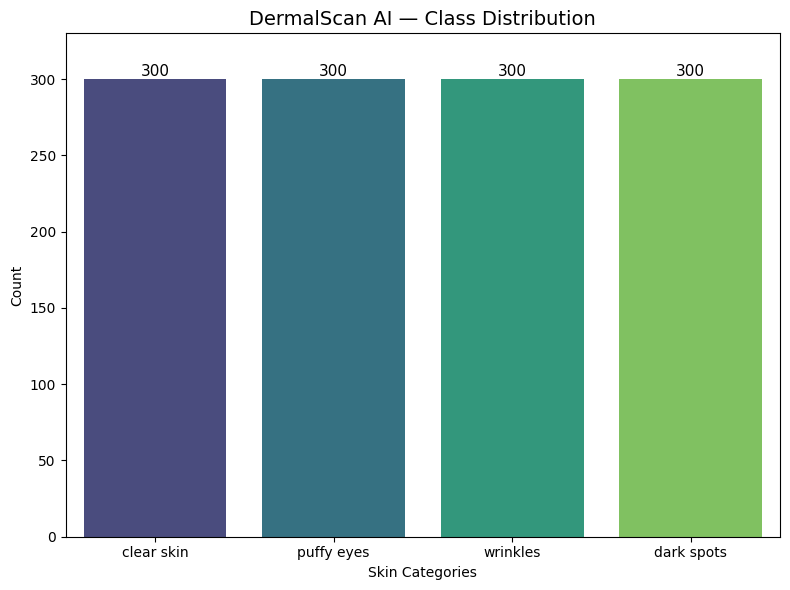


 Preprocessing Completed


In [25]:
# ============================================
#  DermalScan AI — Preprocessing
# ============================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from google.colab import drive

# --- Configuration ---
# --- Configuration ---

BASE_DIR = "/content/drive/MyDrive/final dermalscan dataset output/augmented"
OUTPUT_DIR = "/content/drive/MyDrive/final dermalscan dataset output/"
CLASSES = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']
IMG_SIZE = 224
RANDOM_STATE = 42

# --- Mount Drive ---
print("Mounting Google Drive...")
drive.mount("/content/drive")

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory set to: {OUTPUT_DIR}")

def load_images(data_dir, classes):
    """Loads images, resizes, and converts BGR to RGB."""
    data = []
    labels = []
    label_names_for_plot = []

    print("Starting image loading and resizing...")
    for idx, label in enumerate(classes):
        path = os.path.join(data_dir, label)
        if not os.path.exists(path):
            print(f" ERROR: Path not found: {path}")
            continue

        print(f"Processing class: {label}")
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)

            if img is not None:
                # Convert BGR (OpenCV default) to RGB (Matplotlib/TF default)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

                data.append(img.astype('float32'))  # Keep [0,255] range
                labels.append(idx)
                label_names_for_plot.append(label)
            else:
                print(f" Warning: Could not read image {img_name}")

    return np.array(data), np.array(labels), label_names_for_plot

# --- Load, Process, and Save Data ---
X, y, label_names = load_images(BASE_DIR, CLASSES)

# Shuffle the data
X, y, label_names = shuffle(X, y, label_names, random_state=RANDOM_STATE)

# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=len(CLASSES))

print(f"\n Images (X) shape: {X.shape} (Range [0, 255])")
print(f" Labels (y_encoded) shape: {y_encoded.shape} (One-Hot Encoded)")

# --- Save .npy files ---
X_data_path = os.path.join(OUTPUT_DIR, 'X1_data_224_rgb.npy')
y_labels_path = os.path.join(OUTPUT_DIR, 'y1_labels_one_hot.npy')

np.save(X_data_path, X)
np.save(y_labels_path, y_encoded)

print(f"\n Data saved to: {X_data_path}")
print(f" Labels saved to: {y_labels_path}")

# --- Visualize Class Distribution ---
plt.figure(figsize=(8, 6))
bars = sns.countplot(x=label_names, palette="viridis")
plt.title("DermalScan AI — Class Distribution", fontsize=14)
plt.xlabel("Skin Categories")
plt.ylabel("Count")
plt.ylim(0, max(np.bincount(y)) * 1.1)

for bar in bars.patches:
    bars.annotate(f'{int(bar.get_height())}',
                  (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                  ha='center', va='bottom', fontsize=11, color='black')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'class_distribution_plot.png'))
plt.show()

print("\n Preprocessing Completed")

In [31]:
# ===========================================
# IMPORTS AND CONFIGURATION
# ===========================================
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# --- Configuration ---
DRIVE_PATH = '/content/drive'
DATA_PATH = os.path.join(DRIVE_PATH, '/content/drive/MyDrive/final dermalscan dataset output')
MODEL_PATH = os.path.join(DATA_PATH, 'final_efficientnet_model1.h5')
CLASSES = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']
NUM_CLASSES = len(CLASSES)
IMG_SIZE = 224
RANDOM_STATE = 42

# --- Hyperparameters ---
INITIAL_LR = 1e-3
FINE_TUNE_LR = 1e-5
BATCH_SIZE = 16
EPOCHS_STAGE1 = 40   # Initial training
EPOCHS_STAGE2 = 40   # Fine-tuning

# --- Mount Drive ---
print("🔗 Mounting Google Drive...")
drive.mount(DRIVE_PATH)


🔗 Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:

#  LOAD PREPROCESSED DATA
# ===========================================
print(" Loading preprocessed dataset...")

try:
    X = np.load(os.path.join(DATA_PATH, 'X1_data_224_rgb.npy'))
    y_encoded = np.load(os.path.join(DATA_PATH, 'y1_labels_one_hot.npy'))
except FileNotFoundError:
    raise FileNotFoundError(" Data files not found. Run the preprocessing script first.")

X = X.astype('float32')  # Keep [0, 255] range
print(f" Data loaded. X shape: {X.shape}, y shape: {y_encoded.shape}")

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)
print(f" Dataset Split | Train: {X_train.shape}, Val: {X_val.shape}")


 Loading preprocessed dataset...
 Data loaded. X shape: (1200, 224, 224, 3), y shape: (1200, 4)
 Dataset Split | Train: (960, 224, 224, 3), Val: (240, 224, 224, 3)


In [33]:

#  CLASS WEIGHTS + DATA GENERATORS
# ===========================================
y_train_labels = np.argmax(y_train, axis=1)
class_weights_val = compute_class_weight('balanced', classes=np.arange(NUM_CLASSES), y=y_train_labels)
class_weights = dict(enumerate(class_weights_val))
print(f"Class Weights: {class_weights}")

# --- Data Augmentation Generators ---
# Training: Augmentations ON
datagen_train = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation: No augmentations
datagen_val = ImageDataGenerator()

train_generator = datagen_train.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = datagen_val.flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)


Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}


In [34]:

#  BUILD MODEL FUNCTION
# ===========================================
def build_model(input_shape=(224, 224, 3), num_classes=4):
    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
    inputs = Input(shape=input_shape)
    x = preprocess_input(inputs)

    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x)
    base_model.trainable = False  # Stage 1: frozen

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model, base_model

model, base_model = build_model(num_classes=NUM_CLASSES)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [35]:

#  STAGE 1: TRAIN CLASSIFICATION HEAD
# ===========================================
print("\n--- Stage 1: Training Classification Head ---")

model.compile(
    optimizer=Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_stage1 = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(os.path.join(DATA_PATH, 'stage1_best1.h5'),
                    monitor='val_accuracy', save_best_only=True, verbose=1)
]

steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS_STAGE1,
    class_weight=class_weights,
    callbacks=callbacks_stage1,
    verbose=2
)



--- Stage 1: Training Classification Head ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40

Epoch 1: val_accuracy improved from -inf to 0.79583, saving model to /content/drive/MyDrive/final dermalscan dataset output/stage1_best1.h5


60/60 - 42s - 692ms/step - accuracy: 0.6594 - loss: 0.8808 - val_accuracy: 0.7958 - val_loss: 0.6093
Epoch 2/40

Epoch 2: val_accuracy improved from 0.79583 to 0.82083, saving model to /content/drive/MyDrive/final dermalscan dataset output/stage1_best1.h5


60/60 - 13s - 220ms/step - accuracy: 0.7969 - loss: 0.5959 - val_accuracy: 0.8208 - val_loss: 0.5357
Epoch 3/40

Epoch 3: val_accuracy improved from 0.82083 to 0.83750, saving model to /content/drive/MyDrive/final dermalscan dataset output/stage1_best1.h5


60/60 - 12s - 207ms/step - accuracy: 0.8104 - loss: 0.5267 - val_accuracy: 0.8375 - val_loss: 0.4727
Epoch 4/40

Epoch 4: val_accuracy improved from 0.83750 to 0.85417, saving model to /content/drive/MyDrive/final dermalscan dataset output/stage1_best1.h5


60/60 - 21s - 347ms/step - accuracy: 0.8469 - loss: 0.4691 - val_accuracy: 0.8542 - val_loss: 0.4810
Epoch 5/40

Epoch 5: val_accuracy did not improve from 0.85417
60/60 - 12s - 198ms/step - accuracy: 0.8396 - loss: 0.4804 - val_accuracy: 0.8333 - val_loss: 0.5035
Epoch 6/40

Epoch 6: val_accuracy did not improve from 0.85417
60/60 - 11s - 187ms/step - accuracy: 0.8417 - loss: 0.4443 - val_accuracy: 0.8292 - val_loss: 0.4959
Epoch 7/40

Epoch 7: val_accuracy did not improve from 0.85417
60/60 - 10s - 173ms/step - accuracy: 0.8562 - loss: 0.4305 - val_accuracy: 0.8333 - val_loss: 0.4853
Epoch 8/40

Epoch 8: val_accuracy did not improve from 0.85417
60/60 - 12s - 195ms/step - accuracy: 0.8521 - loss: 0.4416 - val_accuracy: 0.8125 - val_loss: 0.5102
Epoch 9/40

Epoch 9: val_accuracy did not improve from 0.85417
60/60 - 12s - 205ms/step - accuracy: 0.8885 - loss: 0.3558 - val_accuracy: 0.8375 - val_loss: 0.4688
Epoch 10/40

Epoch 10: val_accuracy did not improve from 0.85417
60/60 - 12s - 

60/60 - 14s - 229ms/step - accuracy: 0.8656 - loss: 0.3975 - val_accuracy: 0.8583 - val_loss: 0.4501
Epoch 12/40

Epoch 12: val_accuracy did not improve from 0.85833
60/60 - 13s - 209ms/step - accuracy: 0.8667 - loss: 0.3986 - val_accuracy: 0.8417 - val_loss: 0.4493
Epoch 13/40

Epoch 13: val_accuracy did not improve from 0.85833
60/60 - 19s - 314ms/step - accuracy: 0.8896 - loss: 0.3534 - val_accuracy: 0.8583 - val_loss: 0.4193
Epoch 14/40

Epoch 14: val_accuracy did not improve from 0.85833
60/60 - 12s - 203ms/step - accuracy: 0.8792 - loss: 0.3869 - val_accuracy: 0.8500 - val_loss: 0.4197
Epoch 15/40

Epoch 15: val_accuracy did not improve from 0.85833
60/60 - 12s - 207ms/step - accuracy: 0.8938 - loss: 0.3384 - val_accuracy: 0.8583 - val_loss: 0.4196
Epoch 16/40

Epoch 16: val_accuracy did not improve from 0.85833
60/60 - 12s - 204ms/step - accuracy: 0.8896 - loss: 0.3506 - val_accuracy: 0.8458 - val_loss: 0.4578
Epoch 17/40

Epoch 17: val_accuracy did not improve from 0.85833
60/6

In [36]:
# ===========================================
# STAGE 2: FINE-TUNING
# ===========================================
print("\n--- Stage 2: Fine-tuning EfficientNet Layers ---")

model.load_weights(os.path.join(DATA_PATH, 'stage1_best1.h5'))
base_model.trainable = True

FINE_TUNE_AT = -30  # Unfreeze top 30 layers
for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False
print(f"🔓 Fine-tuning: Unfreezing the top {abs(FINE_TUNE_AT)} layers.")

model.compile(
    optimizer=Adam(learning_rate=FINE_TUNE_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_stage2 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)
]

history_stage2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_STAGE2,
    class_weight=class_weights,
    callbacks=callbacks_stage2,
    verbose=2
)

print(f"\n✅ Training Complete. Final model saved to: {MODEL_PATH}")



--- Stage 2: Fine-tuning EfficientNet Layers ---
🔓 Fine-tuning: Unfreezing the top 30 layers.
Epoch 1/40

Epoch 1: val_accuracy improved from -inf to 0.87083, saving model to /content/drive/MyDrive/final dermalscan dataset output/final_efficientnet_model1.h5


60/60 - 50s - 835ms/step - accuracy: 0.6865 - loss: 0.9421 - val_accuracy: 0.8708 - val_loss: 0.4215 - learning_rate: 1.0000e-05
Epoch 2/40

Epoch 2: val_accuracy improved from 0.87083 to 0.87500, saving model to /content/drive/MyDrive/final dermalscan dataset output/final_efficientnet_model1.h5


60/60 - 14s - 225ms/step - accuracy: 0.7479 - loss: 0.7683 - val_accuracy: 0.8750 - val_loss: 0.4412 - learning_rate: 1.0000e-05
Epoch 3/40

Epoch 3: val_accuracy did not improve from 0.87500
60/60 - 13s - 210ms/step - accuracy: 0.7583 - loss: 0.7063 - val_accuracy: 0.8750 - val_loss: 0.4573 - learning_rate: 1.0000e-05
Epoch 4/40

Epoch 4: val_accuracy did not improve from 0.87500

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
60/60 - 11s - 178ms/step - accuracy: 0.8000 - loss: 0.5885 - val_accuracy: 0.8583 - val_loss: 0.4630 - learning_rate: 1.0000e-05
Epoch 5/40

Epoch 5: val_accuracy did not improve from 0.87500
60/60 - 11s - 191ms/step - accuracy: 0.7802 - loss: 0.6471 - val_accuracy: 0.8625 - val_loss: 0.4670 - learning_rate: 5.0000e-06
Epoch 6/40

Epoch 6: val_accuracy did not improve from 0.87500
60/60 - 12s - 196ms/step - accuracy: 0.7917 - loss: 0.6023 - val_accuracy: 0.8583 - val_loss: 0.4689 - learning_rate: 5.0000e-06
Epoch 7/40

Epoch 7: val_a

In [37]:
#  Evaluate Final Model Accuracy & Loss

from tensorflow.keras.models import load_model

# Path to your best saved model
best_model_path = "/content/drive/MyDrive/final dermalscan dataset output/final_efficientnet_model1.h5"

# Load the best model (restored from the best epoch)
best_model = load_model(best_model_path)

# Evaluate on validation data (or test data if available)
val_loss, val_accuracy = best_model.evaluate(X_val, y_val, verbose=1)

print("\n✅ Final Model Performance:")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 785ms/step - accuracy: 0.8592 - loss: 0.4825

✅ Final Model Performance:
Validation Accuracy: 87.50%
Validation Loss: 0.4412



📈 Generating training history plots...


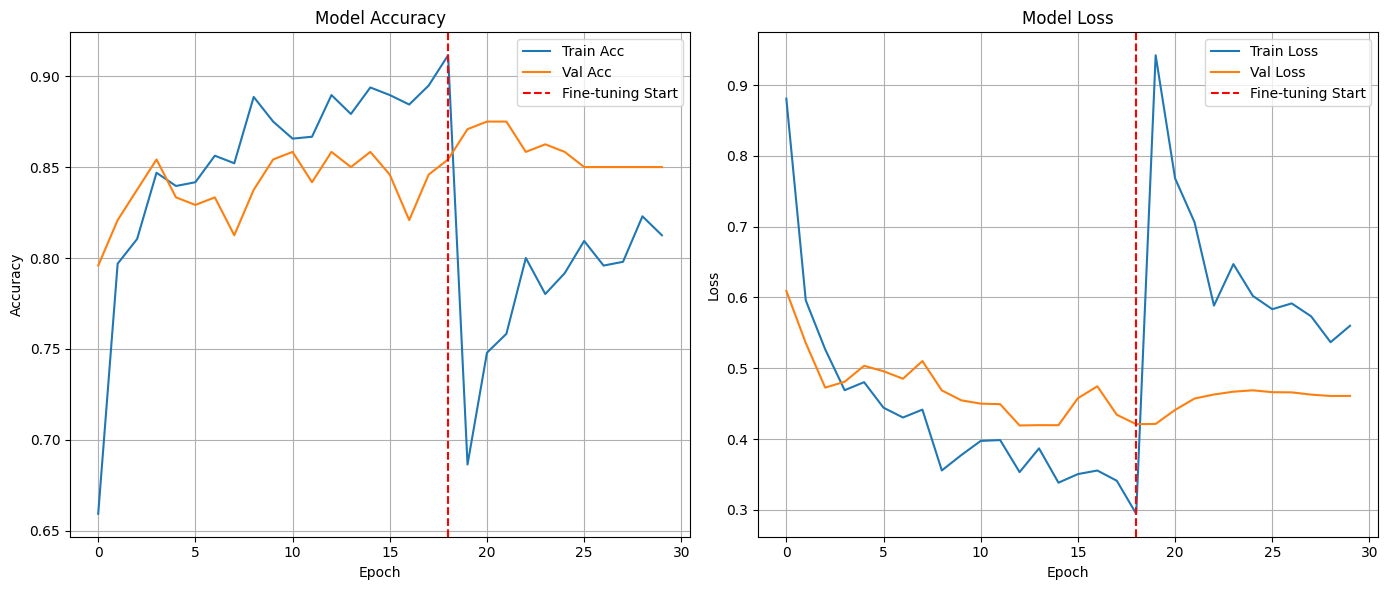

In [38]:
# ===========================================
# 📊 PLOT TRAINING CURVES
# ===========================================
def plot_history(history1, history2):
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs_stage1 = len(history1.history['accuracy'])

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.axvline(epochs_stage1 - 1, color='red', linestyle='--', label='Fine-tuning Start')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.axvline(epochs_stage1 - 1, color='red', linestyle='--', label='Fine-tuning Start')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(DATA_PATH, 'training_curves.png'))
    plt.show()

print("\n📈 Generating training history plots...")
plot_history(history_stage1, history_stage2)


📥 Loading best fine-tuned model for evaluation...

🔍 Generating classification report and confusion matrix...
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step

Classification Report:
              precision    recall  f1-score   support

    wrinkles       0.83      0.80      0.81        60
  dark spots       0.98      0.95      0.97        60
  puffy eyes       0.83      0.80      0.81        60
  clear skin       0.86      0.95      0.90        60

    accuracy                           0.88       240
   macro avg       0.88      0.88      0.87       240
weighted avg       0.88      0.88      0.87       240



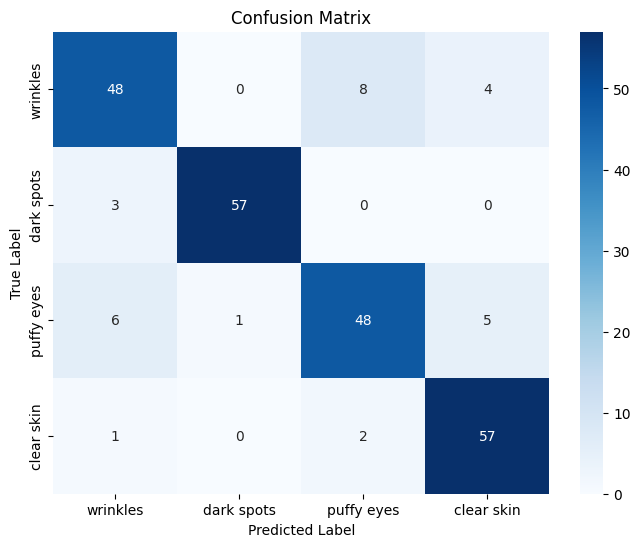


🎯 --- Model Training and Evaluation Complete ---


In [39]:

# 📉 CONFUSION MATRIX & CLASSIFICATION REPORT
# ===========================================
def plot_confusion_matrix(model, x_val, y_val_one_hot, class_names):
    print("\n🔍 Generating classification report and confusion matrix...")
    y_pred = model.predict(x_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_one_hot, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(DATA_PATH, 'confusion_matrix.png'))
    plt.show()

print("📥 Loading best fine-tuned model for evaluation...")
model.load_weights(MODEL_PATH)
plot_confusion_matrix(model, X_val, y_val, CLASSES)

print("\n🎯 --- Model Training and Evaluation Complete ---")


# **Testing Unseen data**

✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


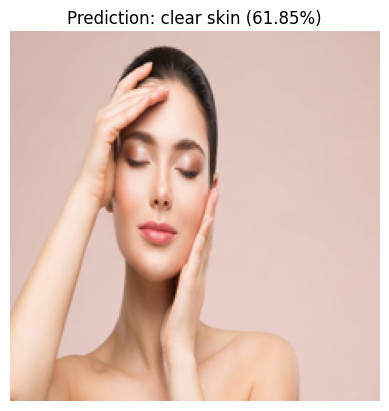

✅ Predicted class: clear skin
Confidence: 61.85%


In [40]:
# ===============================
# 🔍 TESTING UNSEEN IMAGES
# ===============================

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image

# --- Define Classes ---
CLASSES = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']

# --- Load your fine-tuned model ---
MODEL_PATH = '/content/drive/MyDrive/final dermalscan dataset output/final_efficientnet_model.h5'
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded successfully!")

# --- Helper Function ---
def predict_image_from_url(img_url):
    """
    Takes an image URL, downloads it, preprocesses it, and predicts the class.
    """
    try:
        # Read the image from URL
        response = requests.get(img_url)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img_resized = img.resize((224, 224))

        # Convert to array
        img_array = np.array(img_resized).astype('float32')
        img_array = np.expand_dims(img_array, axis=0)

        # EfficientNet preprocessing
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input
        img_preprocessed = preprocess_input(img_array)

        # Predict
        preds = model.predict(img_preprocessed)
        predicted_class = CLASSES[np.argmax(preds)]
        confidence = np.max(preds) * 100

        # Display result
        plt.imshow(img_resized)
        plt.axis("off")
        plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
        plt.show()

        print(f"✅ Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")

    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")

# --- 🔽 Example: Try with any Google Image URL ---
test_image_url = "https://knottstdermatology.com/wp-content/uploads/2023/04/shutterstock_1912937857-scaled.jpg"  # Replace with your own Google image URL
predict_image_from_url(test_image_url)


✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


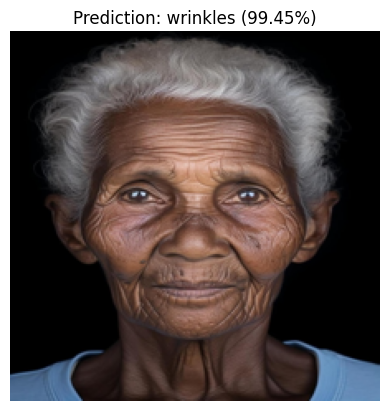

✅ Predicted class: wrinkles
Confidence: 99.45%


In [41]:
# ===============================
# 🔍 TESTING UNSEEN IMAGES
# ===============================

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image

# --- Define Classes ---
CLASSES = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']

# --- Load your fine-tuned model ---
MODEL_PATH = '/content/drive/MyDrive/final dermalscan dataset output/final_efficientnet_model.h5'
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded successfully!")

# --- Helper Function ---
def predict_image_from_url(img_url):
    """
    Takes an image URL, downloads it, preprocesses it, and predicts the class.
    """
    try:
        # Read the image from URL
        response = requests.get(img_url)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img_resized = img.resize((224, 224))

        # Convert to array
        img_array = np.array(img_resized).astype('float32')
        img_array = np.expand_dims(img_array, axis=0)

        # EfficientNet preprocessing
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input
        img_preprocessed = preprocess_input(img_array)

        # Predict
        preds = model.predict(img_preprocessed)
        predicted_class = CLASSES[np.argmax(preds)]
        confidence = np.max(preds) * 100

        # Display result
        plt.imshow(img_resized)
        plt.axis("off")
        plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
        plt.show()

        print(f"✅ Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")

    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")

# --- 🔽 Example: Try with any Google Image URL ---
test_image_url = "https://img.freepik.com/premium-photo/older-woman-with-wrinkles-her-face-black-background_662214-648019.jpg"  # Replace with your own Google image URL
predict_image_from_url(test_image_url)


✅ Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


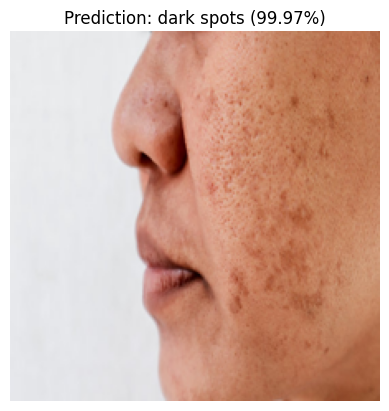

✅ Predicted class: dark spots
Confidence: 99.97%


In [42]:
# ===============================
# 🔍 TESTING UNSEEN IMAGES
# ===============================

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image

# --- Define Classes ---
CLASSES = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']

# --- Load your fine-tuned model ---
MODEL_PATH = '/content/drive/MyDrive/final dermalscan dataset output/final_efficientnet_model.h5'
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded successfully!")

# --- Helper Function ---
def predict_image_from_url(img_url):
    """
    Takes an image URL, downloads it, preprocesses it, and predicts the class.
    """
    try:
        # Read the image from URL
        response = requests.get(img_url)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img_resized = img.resize((224, 224))

        # Convert to array
        img_array = np.array(img_resized).astype('float32')
        img_array = np.expand_dims(img_array, axis=0)

        # EfficientNet preprocessing
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input
        img_preprocessed = preprocess_input(img_array)

        # Predict
        preds = model.predict(img_preprocessed)
        predicted_class = CLASSES[np.argmax(preds)]
        confidence = np.max(preds) * 100

        # Display result
        plt.imshow(img_resized)
        plt.axis("off")
        plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
        plt.show()

        print(f"✅ Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")

    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")

# --- 🔽 Example: Try with any Google Image URL ---
test_image_url = "https://t3.ftcdn.net/jpg/02/89/04/78/360_F_289047889_G3ygGGnhxYaDg3mcQbDX14sg7viE7s8D.jpg"  # Replace with your own Google image URL
predict_image_from_url(test_image_url)


✅ Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


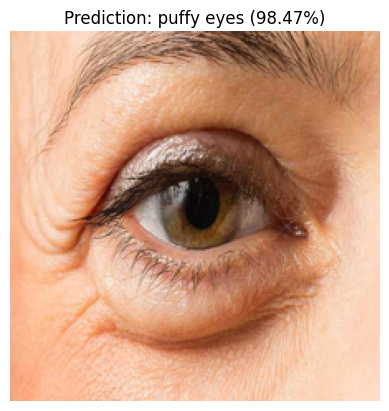

✅ Predicted class: puffy eyes
Confidence: 98.47%


In [43]:
# ===============================
# 🔍 TESTING UNSEEN IMAGES
# ===============================

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image

# --- Define Classes ---
CLASSES = ['wrinkles', 'dark spots', 'puffy eyes', 'clear skin']

# --- Load your fine-tuned model ---
MODEL_PATH = '/content/drive/MyDrive/final dermalscan dataset output/final_efficientnet_model.h5'
model = tf.keras.models.load_model(MODEL_PATH)
print("✅ Model loaded successfully!")

# --- Helper Function ---
def predict_image_from_url(img_url):
    """
    Takes an image URL, downloads it, preprocesses it, and predicts the class.
    """
    try:
        # Read the image from URL
        response = requests.get(img_url)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img_resized = img.resize((224, 224))

        # Convert to array
        img_array = np.array(img_resized).astype('float32')
        img_array = np.expand_dims(img_array, axis=0)

        # EfficientNet preprocessing
        preprocess_input = tf.keras.applications.efficientnet.preprocess_input
        img_preprocessed = preprocess_input(img_array)

        # Predict
        preds = model.predict(img_preprocessed)
        predicted_class = CLASSES[np.argmax(preds)]
        confidence = np.max(preds) * 100

        # Display result
        plt.imshow(img_resized)
        plt.axis("off")
        plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)")
        plt.show()

        print(f"✅ Predicted class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")

    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")

# --- 🔽 Example: Try with any Google Image URL ---
test_image_url = "https://media.allaboutvision.com/cms/caas/v1/media/404898/data/picture/c359af3d5e4654c3de7ebb4109dd98d2.jpg"  # Replace with your own Google image URL
predict_image_from_url(test_image_url)
